Cooling_1468959484_96_sorted.csv
2016-07-19 14:18:04.960000
Loaded data with shape: (358, 18).
(100.0, 1000.0, 10000.0) frequencies found


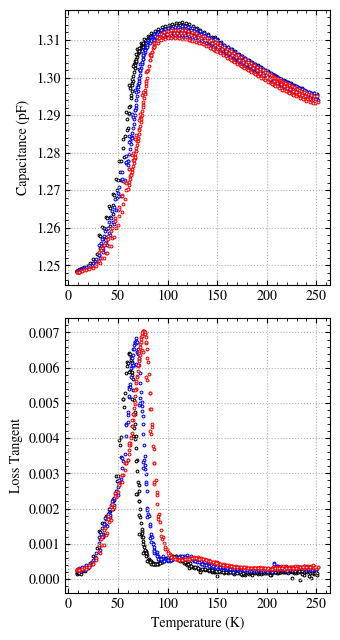

In [1]:
from fitting.debye33 import Debye33, Debye33AAA, Debye33AAF, Debye33FFA
from fitting.cole_cole import ColeCole
from fitting.data import DataSetOld
from pathlib import Path
from datetime import datetime
from scipy.optimize import least_squares
import numpy as np
import matplotlib.pylab as plt
import matplotlib
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams["mathtext.fontset"] = "cm"
%matplotlib inline

dir = Path(r'C:\Users\Teddy\OneDrive - UCB-O365\Rogerslab3\Teddy\Thesis\chapter-4\Data\BDS')

# calibration_files = list(dir.glob("Calibration*"))
# data_files = list(dir.glob("HeliumCool*"))
try:
    data_file = list((dir / "1@TPP sat - GBA 124").glob("*"))[1]
except IndexError:
    dir = Path(r'D:\OneDrive - UCB-O365\Rogerslab3\Teddy\Thesis\chapter-4\Data\BDS')
    data_file = list((dir / "1@TPP sat - GBA 124").glob("*"))[1]
print(data_file.name)
x = data_file.name.split("_")[1:3]
date_time = float(x[0] + "." + x[1])
del x
print(datetime.fromtimestamp(date_time))

data = DataSetOld(data_file)
fig, _ = data.show()

(1000, 3)


(<Figure size 400x900 with 2 Axes>,
 array([<Axes: title={'center': '40%-1@TPP'}, xlabel='Temperature (K)', ylabel='Capacitance (pF)'>,
        <Axes: xlabel='Temperature (K)', ylabel="$C''$ (pF)">],
       dtype=object))

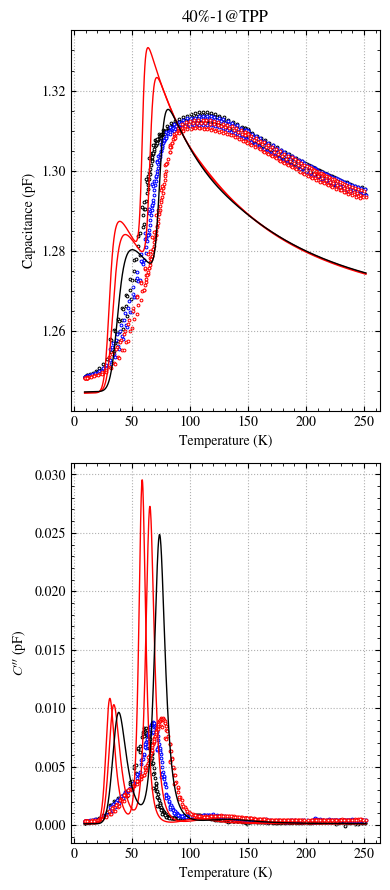

In [2]:
fit = ColeCole(data, "40%-1@TPP")
peaks = 3
fit.ln_attempt_time   = np.ones((peaks, 1, 1), dtype=np.float64) * -29
fit.activation_energy = np.array([700, 1326.4, 2426.14]).reshape((peaks, 1, 1))
fit.coupling_energy   = np.ones((peaks, 1, 1), dtype=np.float64) * 20
fit.cole_term         = np.zeros((peaks, 1, 1), dtype=np.float64)
fit.cole_term[0,0,0]  = .5
fit.cole_term[2,0,0]  = .5
fit.population        = np.array([10, 17, 1,]).reshape((peaks, 1, 1))
fit.bare0 = np.array([1.1897, 1.1899, 1.19])
fit.bare1 = 1.93e-5
fit.bare2 = 2.496e-8
fit.td0 = 1e-4
fit.td1 = 0
fit.td2 = 0
fit.emat0 = 1.235
fit.emat1 = 1e-5
weights = 1e-3
fit.show_fit()

[1.235, 1e-05, 10, 17, 1, 20.0, 20.0, 20.0]
reduced Chi^2 = 2.111915654067071
     message: `ftol` termination condition is satisfied.
     success: True
      status: 2
         fun: [ 1.429e+00  1.525e+00 ...  7.749e-01  9.411e-01]
           x: [ 1.256e+00 -5.044e-05  3.585e+01  2.317e+01 -3.327e-01
                1.035e+02  1.065e+02  1.096e+02]
        cost: 2253.4140028895645
         jac: [[-2.477e+02 -6.214e+04 ...  0.000e+00  0.000e+00]
               [-2.429e+02 -6.073e+04 ...  1.278e-01  0.000e+00]
               ...
               [ 2.307e+02  5.585e+04 ... -1.252e-01  0.000e+00]
               [ 2.214e+02  5.372e+04 ...  0.000e+00 -1.199e-01]]
        grad: [ 2.201e+01 -3.144e+04  7.175e-02  6.296e-02  1.406e-02
               -1.957e-02 -1.740e-02 -1.346e-02]
  optimality: 31441.44638940881
 active_mask: [0 0 0 0 0 0 0 0]
        nfev: 521
        njev: None
[ 1.25551460e+00 -5.04352511e-05  3.58541661e+01  2.31661280e+01
 -3.32746248e-01  1.03531906e+02  1.06536786e+02 

(<Figure size 400x900 with 2 Axes>,
 array([<Axes: title={'center': '40%-1@TPP'}, xlabel='Temperature (K)', ylabel='Capacitance (pF)'>,
        <Axes: xlabel='Temperature (K)', ylabel="$C''$ (pF)">],
       dtype=object))

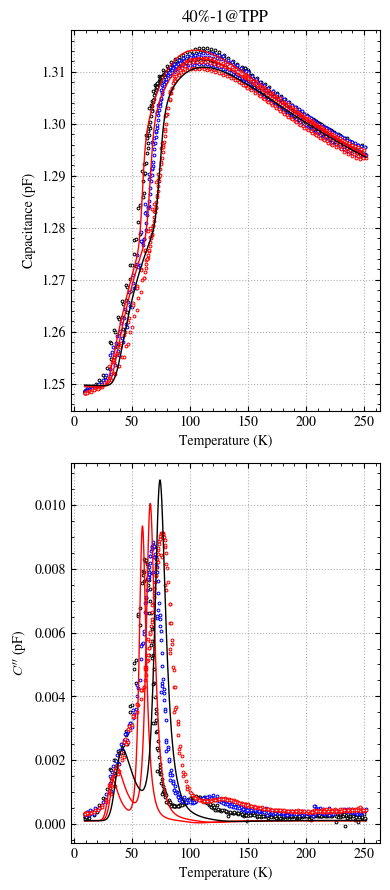

In [3]:
params = [fit.emat0, fit.emat1]
params.extend(fit.population.flatten())
# params.extend(fit.activation_energy.flatten())
params.extend(fit.coupling_energy.flatten())

print(params)

def residuals(params: list, fit: ColeCole):
    emat0, emat1 = params[:2]
    population = np.array(params[2:2+peaks]).reshape((peaks, 1, 1))
    # activation_energy = np.array(params[2+peaks:2*(1+peaks)])
    coupling_energy = np.array(params[2+peaks:2*(1+peaks)])
    cap, imag = fit.fitting_function(fit.temperature, fit.angular_frequency, fit.curie_temperature, fit.ln_attempt_time,
                                     fit.activation_energy,
                                     coupling_energy, population, fit.cole_term, emat0, emat1,
                                     fit.bare0, fit.bare1, fit.bare2, fit.td0, fit.td1, fit.td2)
    cap_error = fit.capacitance - cap
    im_error = fit.imaginary_capacitance - imag
    return np.sqrt(cap_error * cap_error + im_error * im_error).flatten() / weights
        
fit_result = least_squares(residuals, params, method='lm', args=(fit,))
# std = np.sqrt(np.diagonal(np.linalg.inv(fit_result.jac.T @ fit_result.jac) * (fit_result.fun.T @ fit_result.fun / (fit_result.fun.size - fit_result.x.size))))

dof = 2. * np.product(fit.temperature.shape) - len(fit_result.x)
reduced_chi_sq = 2 * fit_result.cost / dof
print(f"reduced Chi^2 = {reduced_chi_sq}")

fit.emat0 = fit_result.x[0]
fit.emat1 = fit_result.x[1]
fit.population = np.array(fit_result.x[2:2+peaks]).reshape((peaks, 1, 1))
# fit.activation_energy = np.array(fit_result.x[2+peaks:2*(1+peaks)])
fit.coupling_energy = np.array(fit_result.x[2+peaks:2*(1+peaks)])

print(fit_result)
print(fit_result.x)
# print(std)

fit.show_fit()

[1.2555145970583654, -5.043525107624739e-05, 35.85416610949711, 23.16612800312195, -0.33274624787114665]
reduced Chi^2 = 4.227793626434455
     message: `ftol` termination condition is satisfied.
     success: True
      status: 2
         fun: [ 1.429e+00  1.525e+00 ...  7.749e-01  9.411e-01]
           x: [ 1.256e+00 -5.044e-05  3.585e+01  2.317e+01 -3.327e-01]
        cost: 2253.4140028895645
         jac: [[-2.477e+02 -6.214e+04 ... -7.681e-01 -7.673e-01]
               [-2.429e+02 -6.073e+04 ... -7.474e-01 -7.453e-01]
               ...
               [ 2.307e+02  5.585e+04 ...  7.177e-01  7.138e-01]
               [ 2.214e+02  5.372e+04 ...  6.819e-01  6.696e-01]]
        grad: [ 2.201e+01 -3.144e+04  7.175e-02  6.296e-02  1.406e-02]
  optimality: 31441.44638940881
 active_mask: [0 0 0 0 0]
        nfev: 7
        njev: None
[ 1.25551460e+00 -5.04352511e-05  3.58541661e+01  2.31661280e+01
 -3.32746248e-01]
(1000, 3)


(<Figure size 400x900 with 2 Axes>,
 array([<Axes: title={'center': '40%-1@TPP'}, xlabel='Temperature (K)', ylabel='Capacitance (pF)'>,
        <Axes: xlabel='Temperature (K)', ylabel="$C''$ (pF)">],
       dtype=object))

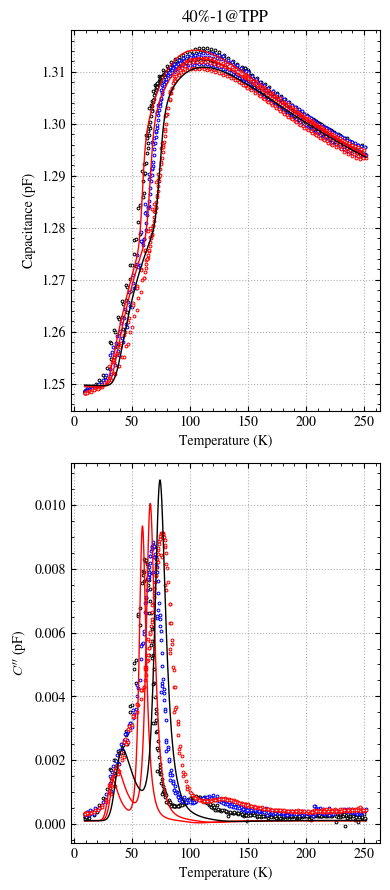

In [4]:
params = [fit.emat0, fit.emat1]
params.extend(fit.population.flatten())
# params.extend(fit.activation_energy.flatten())
# params.extend(fit.coupling_energy.flatten())

print(params)

def residuals(params: list, fit: ColeCole):
    emat0, emat1 = params[:2]
    population = np.array(params[2:2+peaks]).reshape((peaks, 1, 1))
    # activation_energy = np.array(params[2+peaks:2*(1+peaks)])
    # coupling_energy = np.array(params[2*(1+peaks):2+3*peaks])
    cap, imag = fit.fitting_function(fit.temperature, fit.angular_frequency, fit.curie_temperature, fit.ln_attempt_time,
                                     fit.activation_energy,
                                     fit.coupling_energy, population, fit.cole_term, emat0, emat1,
                                     fit.bare0, fit.bare1, fit.bare2, fit.td0, fit.td1, fit.td2)
    cap_error = fit.capacitance - cap
    im_error = fit.imaginary_capacitance - imag
    return np.sqrt(cap_error * cap_error + im_error * im_error).flatten() / weights
        
fit_result = least_squares(residuals, params, method='lm', args=(fit,))
# std = np.sqrt(np.diagonal(np.linalg.inv(fit_result.jac.T @ fit_result.jac) * (fit_result.fun.T @ fit_result.fun / (fit_result.fun.size - fit_result.x.size))))

dof = np.product(fit.temperature.shape) - len(fit_result.x)
reduced_chi_sq = 2 * fit_result.cost / dof
print(f"reduced Chi^2 = {reduced_chi_sq}")

fit.emat0 = fit_result.x[0]
fit.emat1 = fit_result.x[1]
fit.population = np.array(fit_result.x[2:2+peaks]).reshape((peaks, 1, 1))
# fit.activation_energy = np.array(fit_result.x[2+peaks:2*(1+peaks)])
# fit.coupling_energy = np.array(fit_result.x[2*(1+peaks):2+3*peaks])

print(fit_result)
print(fit_result.x)
# print(std)

fit.show_fit()

[1.2555145970583654, -5.043525107624739e-05, 35.85416610949711, 23.16612800312195, -0.33274624787114665, 103.53190641240157, 106.53678591404277, 109.60002535684585]
reduced Chi^2 = 2.111915653850232
     message: `ftol` termination condition is satisfied.
     success: True
      status: 2
         fun: [ 1.429e+00  1.525e+00 ...  7.749e-01  9.412e-01]
           x: [ 1.256e+00 -5.043e-05  3.585e+01  2.317e+01 -3.322e-01
                1.035e+02  1.065e+02  1.096e+02]
        cost: 2253.4140026581977
         jac: [[-2.477e+02 -6.214e+04 ...  0.000e+00  0.000e+00]
               [-2.429e+02 -6.073e+04 ...  1.278e-01  0.000e+00]
               ...
               [ 2.307e+02  5.585e+04 ... -1.252e-01  0.000e+00]
               [ 2.215e+02  5.372e+04 ...  0.000e+00 -1.199e-01]]
        grad: [-1.916e+01 -3.466e+04 -6.977e-02 -5.989e-02 -4.978e-03
                2.083e-02  1.993e-02  1.397e-02]
  optimality: 34657.08480562823
 active_mask: [0 0 0 0 0 0 0 0]
        nfev: 10
        njev:

(<Figure size 400x900 with 2 Axes>,
 array([<Axes: title={'center': '40%-1@TPP'}, xlabel='Temperature (K)', ylabel='Capacitance (pF)'>,
        <Axes: xlabel='Temperature (K)', ylabel="$C''$ (pF)">],
       dtype=object))

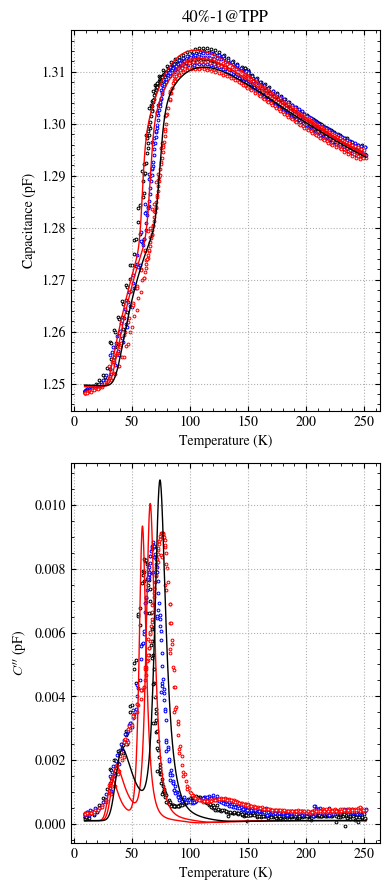

In [5]:
params = [fit.emat0, fit.emat1]
params.extend(fit.population.flatten())
# params.extend(fit.activation_energy.flatten())
params.extend(fit.coupling_energy.flatten())

print(params)

def residuals(params: list, fit: ColeCole):
    emat0, emat1 = params[:2]
    population = np.array(params[2:2+peaks]).reshape((peaks, 1, 1))
    # activation_energy = np.array(params[2+peaks:2*(1+peaks)])
    coupling_energy = np.array(params[2+peaks:2*(1+peaks)])
    cap, imag = fit.fitting_function(fit.temperature, fit.angular_frequency, fit.curie_temperature, fit.ln_attempt_time,
                                     fit.activation_energy,
                                     coupling_energy, population, fit.cole_term, emat0, emat1,
                                     fit.bare0, fit.bare1, fit.bare2, fit.td0, fit.td1, fit.td2)
    cap_error = fit.capacitance - cap
    im_error = fit.imaginary_capacitance - imag
    return np.sqrt(cap_error * cap_error + im_error * im_error).flatten() / weights
        
fit_result = least_squares(residuals, params, method='lm', args=(fit,))
# std = np.sqrt(np.diagonal(np.linalg.inv(fit_result.jac.T @ fit_result.jac) * (fit_result.fun.T @ fit_result.fun / (fit_result.fun.size - fit_result.x.size))))

dof = 2 * np.product(fit.temperature.shape) - len(fit_result.x)
reduced_chi_sq = 2 * fit_result.cost / dof
print(f"reduced Chi^2 = {reduced_chi_sq}")

fit.emat0 = fit_result.x[0]
fit.emat1 = fit_result.x[1]
fit.population = np.array(fit_result.x[2:2+peaks]).reshape((peaks, 1, 1))
# fit.activation_energy = np.array(fit_result.x[2+peaks:2*(1+peaks)])
fit.coupling_energy = np.array(fit_result.x[2+peaks:2*(1+peaks)])

print(fit_result)
print(fit_result.x)
# print(std)

fit.show_fit()

[1.2555137010633854, -5.042923797101405e-05, 35.8536302261945, 23.16596622869124, -0.33224549860165375, 700.0, 1326.4, 2426.14, 103.53146441880442, 106.53631444443215, 109.59943106396912]
reduced Chi^2 = 0.4713319629837505
     message: `ftol` termination condition is satisfied.
     success: True
      status: 2
         fun: [ 4.526e-02  3.043e-01 ...  2.815e-01  4.173e-01]
           x: [ 1.256e+00 -5.043e-05  1.861e+02  2.888e-01 -1.776e+02
                1.355e+03  1.352e+03  1.334e+03 -9.348e+00 -3.192e+01
               -7.751e+01]
        cost: 249.80594038138779
         jac: [[ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]
               [ 0.000e+00  0.000e+00 ...  6.580e-06  0.000e+00]
               ...
               [ 0.000e+00  0.000e+00 ...  7.067e-06  0.000e+00]
               [ 0.000e+00  0.000e+00 ...  0.000e+00  1.875e-05]]
        grad: [ 0.000e+00  0.000e+00 -3.876e-05  4.016e-04 -3.876e-05
                2.803e-05  4.023e-05  4.579e-05  3.654e-06 -7.223e-06
 

(<Figure size 400x900 with 2 Axes>,
 array([<Axes: title={'center': '40%-1@TPP'}, xlabel='Temperature (K)', ylabel='Capacitance (pF)'>,
        <Axes: xlabel='Temperature (K)', ylabel="$C''$ (pF)">],
       dtype=object))

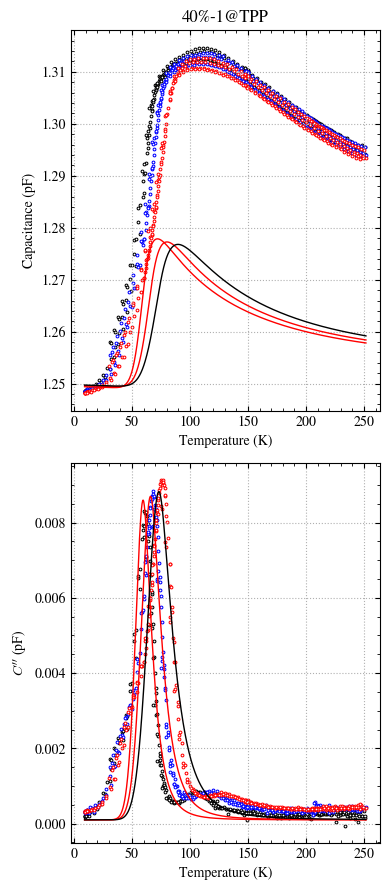

In [6]:
params = [fit.emat0, fit.emat1]
params.extend(fit.population.flatten())
params.extend(fit.activation_energy.flatten())
params.extend(fit.coupling_energy.flatten())

print(params)

def residuals(params: list, fit: ColeCole):
    emat0, emat1 = params[:2]
    population = np.array(params[2:2+peaks]).reshape((peaks, 1, 1))
    activation_energy = np.array(params[2+peaks:2*(1+peaks)])
    coupling_energy = np.array(params[2*(1+peaks):2+3*peaks])
    cap, imag = fit.fitting_function(fit.temperature, fit.angular_frequency, fit.curie_temperature, fit.ln_attempt_time,
                                     activation_energy,
                                     coupling_energy, population, fit.cole_term, emat0, emat1,
                                     fit.bare0, fit.bare1, fit.bare2, fit.td0, fit.td1, fit.td2)
    cap_error = fit.capacitance - cap
    im_error = fit.imaginary_capacitance - imag
    return im_error.flatten() / weights
        
fit_result = least_squares(residuals, params, method='lm', args=(fit,))
# std = np.sqrt(np.diagonal(np.linalg.inv(fit_result.jac.T @ fit_result.jac) * (fit_result.fun.T @ fit_result.fun / (fit_result.fun.size - fit_result.x.size))))

dof = np.product(fit.temperature.shape) - len(fit_result.x)
reduced_chi_sq = 2 * fit_result.cost / dof
print(f"reduced Chi^2 = {reduced_chi_sq}")

fit.emat0 = fit_result.x[0]
fit.emat1 = fit_result.x[1]
fit.population = np.array(fit_result.x[2:2+peaks]).reshape((peaks, 1, 1))
fit.activation_energy = np.array(fit_result.x[2+peaks:2*(1+peaks)])
fit.coupling_energy = np.array(fit_result.x[2*(1+peaks):2+3*peaks])

print(fit_result)
print(fit_result.x)
# print(std)

fit.show_fit()

[1.2555137010633854, -5.042923797101405e-05, 186.06016010518525, 0.2887672991519513, -177.55460928724779, 1354.988593683375, 1352.2522235036622, 1333.7953282398148, -9.348326606388058, -31.92323022307289, -77.51202979691392]
reduced Chi^2 = 35.128628539430466
     message: `ftol` termination condition is satisfied.
     success: True
      status: 2
         fun: [ 4.036e+00  3.713e+00 ...  4.806e+00  4.381e+00]
           x: [ 1.180e+00  3.616e-03  3.791e+02 -1.153e+03  1.479e+01
                2.103e+03  1.879e+03  9.506e+02  4.180e+02  4.174e+02
                4.161e+02]
        cost: 18618.173125898145
         jac: [[ 2.479e+02  6.217e+04 ...  0.000e+00  0.000e+00]
               [ 2.475e+02  6.197e+04 ...  8.164e-01  0.000e+00]
               ...
               [ 2.477e+02  6.108e+04 ...  8.194e-01  0.000e+00]
               [ 2.470e+02  6.097e+04 ...  0.000e+00  8.214e-01]]
        grad: [ 4.753e+01 -1.370e+03  9.029e-04  9.106e-04  9.029e-04
               -2.360e-04 -9.657e-

(<Figure size 400x900 with 2 Axes>,
 array([<Axes: title={'center': '40%-1@TPP'}, xlabel='Temperature (K)', ylabel='Capacitance (pF)'>,
        <Axes: xlabel='Temperature (K)', ylabel="$C''$ (pF)">],
       dtype=object))

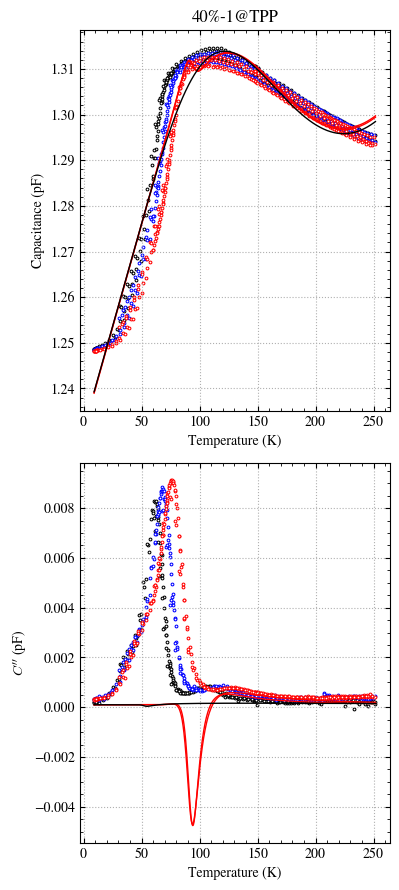

In [7]:
params = [fit.emat0, fit.emat1]
params.extend(fit.population.flatten())
params.extend(fit.activation_energy.flatten())
params.extend(fit.coupling_energy.flatten())

print(params)

def residuals(params: list, fit: ColeCole):
    emat0, emat1 = params[:2]
    population = np.array(params[2:2+peaks]).reshape((peaks, 1, 1))
    activation_energy = np.array(params[2+peaks:2*(1+peaks)])
    coupling_energy = np.array(params[2*(1+peaks):2+3*peaks])
    cap, imag = fit.fitting_function(fit.temperature, fit.angular_frequency, fit.curie_temperature, fit.ln_attempt_time,
                                     activation_energy,
                                     coupling_energy, population, fit.cole_term, emat0, emat1,
                                     fit.bare0, fit.bare1, fit.bare2, fit.td0, fit.td1, fit.td2)
    cap_error = fit.capacitance - cap
    im_error = fit.imaginary_capacitance - imag
    return np.sqrt(cap_error * cap_error + im_error * im_error).flatten() / weights
        
fit_result = least_squares(residuals, params, method='lm', args=(fit,))
# std = np.sqrt(np.diagonal(np.linalg.inv(fit_result.jac.T @ fit_result.jac) * (fit_result.fun.T @ fit_result.fun / (fit_result.fun.size - fit_result.x.size))))

dof = np.product(fit.temperature.shape) - len(fit_result.x)
reduced_chi_sq = 2 * fit_result.cost / dof
print(f"reduced Chi^2 = {reduced_chi_sq}")

fit.emat0 = fit_result.x[0]
fit.emat1 = fit_result.x[1]
fit.population = np.array(fit_result.x[2:2+peaks]).reshape((peaks, 1, 1))
fit.activation_energy = np.array(fit_result.x[2+peaks:2*(1+peaks)])
fit.coupling_energy = np.array(fit_result.x[2*(1+peaks):2+3*peaks])

print(fit_result)
print(fit_result.x)
# print(std)

fit.show_fit()

[1.1801195887471223, 0.003615601879590434, 379.12207226630306, -1152.6660365031348, 14.788839917740301, 418.0240360705811, 417.44853881827595, 416.0962847078643]
reduced Chi^2 = 35.02948840174816
     message: `ftol` termination condition is satisfied.
     success: True
      status: 2
         fun: [ 4.036e+00  3.713e+00 ...  4.806e+00  4.381e+00]
           x: [ 1.180e+00  3.616e-03 -6.202e+01 -1.153e+03  4.560e+02
                4.180e+02  4.175e+02  4.161e+02]
        cost: 18618.173085529146
         jac: [[ 2.479e+02  6.217e+04 ...  0.000e+00  0.000e+00]
               [ 2.475e+02  6.197e+04 ...  8.164e-01  0.000e+00]
               ...
               [ 2.477e+02  6.108e+04 ...  8.194e-01  0.000e+00]
               [ 2.470e+02  6.097e+04 ...  0.000e+00  8.214e-01]]
        grad: [-7.794e+00 -5.965e+03 -2.647e-04 -3.664e-04 -2.646e-04
               -1.930e-03 -2.096e-03 -1.076e-04]
  optimality: 5965.471831148025
 active_mask: [0 0 0 0 0 0 0 0]
        nfev: 62
        njev: No

(<Figure size 400x900 with 2 Axes>,
 array([<Axes: title={'center': '40%-1@TPP'}, xlabel='Temperature (K)', ylabel='Capacitance (pF)'>,
        <Axes: xlabel='Temperature (K)', ylabel="$C''$ (pF)">],
       dtype=object))

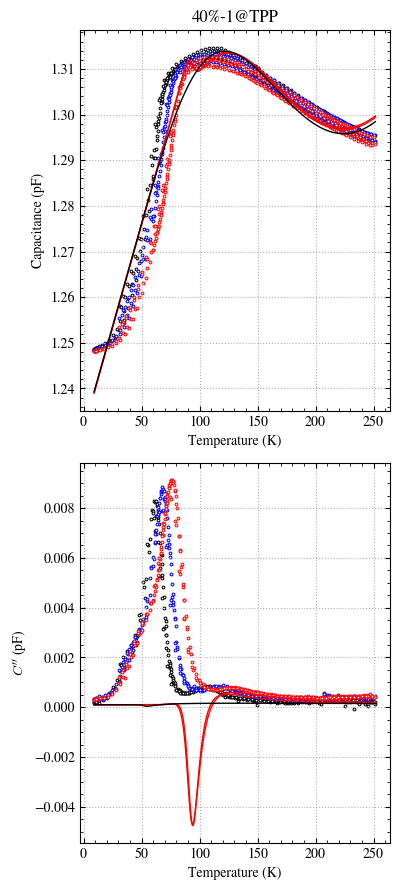

In [8]:
params = [fit.emat0, fit.emat1]
params.extend(fit.population.flatten())
params.extend(fit.coupling_energy.flatten())

print(params)

def residuals(params: list, fit: ColeCole):
    emat0, emat1 = params[:2]
    population = np.array(params[2:2+peaks]).reshape((peaks, 1, 1))
    coupling_energy = np.array(params[2+peaks:2*(1+peaks)])
    cap, imag = fit.fitting_function(fit.temperature, fit.angular_frequency, fit.curie_temperature, fit.ln_attempt_time,
                                     fit.activation_energy,
                                     coupling_energy, population, fit.cole_term, emat0, emat1,
                                     fit.bare0, fit.bare1, fit.bare2, fit.td0, fit.td1, fit.td2)
    cap_error = fit.capacitance - cap
    im_error = fit.imaginary_capacitance - imag
    return np.sqrt(cap_error * cap_error + im_error * im_error).flatten() / weights
        
fit_result = least_squares(residuals, params, method='lm', args=(fit,))
std = np.sqrt(np.diagonal(np.linalg.inv(fit_result.jac.T @ fit_result.jac) * (fit_result.fun.T @ fit_result.fun / (fit_result.fun.size - fit_result.x.size))))

dof = np.product(fit.temperature.shape) - len(fit_result.x)
reduced_chi_sq = 2 * fit_result.cost / dof
print(f"reduced Chi^2 = {reduced_chi_sq}")

fit.emat0 = fit_result.x[0]
fit.emat1 = fit_result.x[1]
fit.population = np.array(fit_result.x[2:2+peaks]).reshape((peaks, 1, 1))
fit.coupling_energy = np.array(fit_result.x[2+peaks:2*(1+peaks)])

print(fit_result)
print(fit_result.x)
print(std)

fit.show_fit()

[1.1801205039840774, 0.0036155581557042373, 418.02620738040247, 417.4507033392411, 416.0984087588451, 0.5, 0.0, 0.5, -62.02060709609049, -1152.7312011212082, 455.9992471495972]


c:\Users\Teddy\Documents\Git\ttortorici\fitting\fitting\cole_cole.py:51: RuntimeWarning: overflow encountered in power
  omega_tau_cole = omega_tau ** (1-cole_term)
c:\Users\Teddy\Documents\Git\ttortorici\fitting\fitting\debye.py:84: RuntimeWarning: overflow encountered in exp
  return 3 / (2 + np.exp(1.5 * coupling_energy / temperature))
c:\Users\Teddy\Documents\Git\ttortorici\fitting\fitting\cole_cole.py:61: RuntimeWarning: overflow encountered in multiply
  denom_inv = population * susceptibility / ((temperature - curie_temperature) * (1.0 + 2.0 * omega_tau_cole * sin_cole + omega_tau_cole * omega_tau_cole))
c:\Users\Teddy\Documents\Git\ttortorici\fitting\fitting\cole_cole.py:61: RuntimeWarning: invalid value encountered in add
  denom_inv = population * susceptibility / ((temperature - curie_temperature) * (1.0 + 2.0 * omega_tau_cole * sin_cole + omega_tau_cole * omega_tau_cole))
c:\Users\Teddy\Documents\Git\ttortorici\fitting\fitting\cole_cole.py:63: RuntimeWarning: invalid value 

reduced Chi^2 = 35.10729446142628
     message: The maximum number of function evaluations is exceeded.
     success: False
      status: 0
         fun: [ 3.372e+00  3.342e+00 ...  4.447e+00  5.300e+00]
           x: [ 1.180e+00  3.612e-03  4.180e+02  4.170e+02  4.144e+02
                2.182e-01  2.159e-01  6.062e-01 -6.325e+01 -1.154e+03
                4.549e+02]
        cost: 18606.86606455593
         jac: [[ 2.476e+02  6.210e+04 ...  2.099e-01  2.121e-01]
               [ 2.479e+02  6.206e+04 ...  2.097e-01  2.114e-01]
               ...
               [ 2.479e+02  6.111e+04 ...  2.060e-01  2.076e-01]
               [ 2.477e+02  6.115e+04 ...  2.062e-01  2.083e-01]]
        grad: [ 5.187e+01  3.546e+04 -8.498e-04  2.829e-01  1.216e+00
               -4.820e-02 -8.010e-01  6.194e+00  5.212e-01  5.214e-01
                4.575e-01]
  optimality: 35455.91621125303
 active_mask: [0 0 0 0 0 0 0 0 0 0 0]
        nfev: 13206
        njev: None
[ 1.18027131e+00  3.61249421e-03  4.18018

(<Figure size 400x900 with 2 Axes>,
 array([<Axes: title={'center': '40%-1@TPP'}, xlabel='Temperature (K)', ylabel='Capacitance (pF)'>,
        <Axes: xlabel='Temperature (K)', ylabel="$C''$ (pF)">],
       dtype=object))

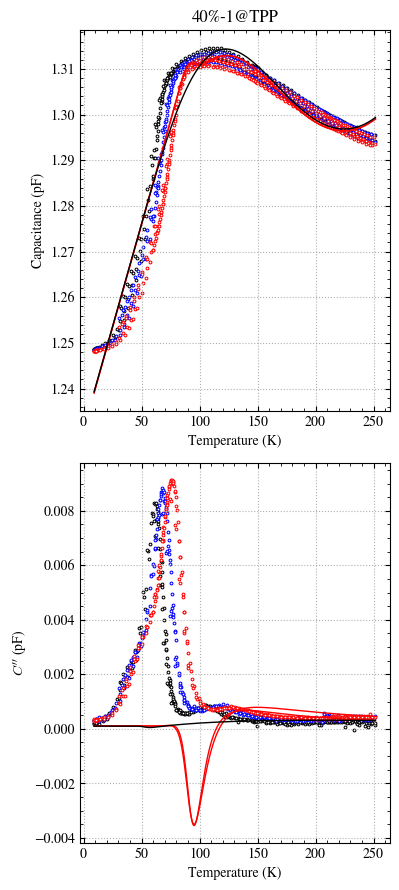

In [9]:
params = [fit.emat0, fit.emat1]
params.extend(fit.coupling_energy.flatten())
params.extend(fit.cole_term.flatten())
params.extend(fit.population.flatten())

print(params)

def residuals(params: list, fit: ColeCole):
    emat0, emat1 = params[:2]
    coupling_energy = np.array(params[2:2+peaks]).reshape((peaks, 1, 1))
    cole_term = np.array(params[2+peaks:2+peaks+peaks]).reshape((peaks, 1, 1))
    population = np.array(params[2+peaks+peaks:2+3*peaks]).reshape((peaks, 1, 1))
    cap, imag = fit.fitting_function(fit.temperature, fit.angular_frequency, fit.curie_temperature, fit.ln_attempt_time,
                                     fit.activation_energy,
                                     coupling_energy, population, cole_term, emat0, emat1,
                                     fit.bare0, fit.bare1, fit.bare2, fit.td0, fit.td1, fit.td2)
    cap_error = fit.capacitance - cap
    im_error = fit.imaginary_capacitance - imag
    return np.sqrt(cap_error * cap_error + im_error * im_error).flatten() / weights
        
fit_result = least_squares(residuals, params, method='lm', args=(fit,))
std = np.sqrt(np.diagonal(np.linalg.inv(fit_result.jac.T @ fit_result.jac) * (fit_result.fun.T @ fit_result.fun / (fit_result.fun.size - fit_result.x.size))))

dof = np.product(fit.temperature.shape) - len(fit_result.x)
reduced_chi_sq = 2 * fit_result.cost / dof
print(f"reduced Chi^2 = {reduced_chi_sq}")

fit.emat0 = fit_result.x[0]
fit.emat1 = fit_result.x[1]
fit.coupling_energy = np.array(fit_result.x[2:2+peaks]).reshape((peaks, 1, 1))
fit.cole_term = np.array(fit_result.x[2+peaks:2+peaks+peaks]).reshape((peaks, 1, 1))
fit.population = np.array(fit_result.x[2+peaks+peaks:2+3*peaks]).reshape((peaks, 1, 1))

print(fit_result)
print(fit_result.x)
print(std)

fit.show_fit()

[1.1802713142616326, 0.0036124942106803655, 418.0187346753722, 416.994225619867, 414.4353347373576, 0.2181591382776074, 0.2158556934179319, 0.6062298189184369, -63.250265401688445, -1153.9613529731794, 454.85352820810834, 2102.8456764205243, 1879.070843957775, 950.5741733545408]


c:\Users\Teddy\Documents\Git\ttortorici\fitting\fitting\cole_cole.py:46: RuntimeWarning: overflow encountered in exp
  tau = np.exp(ln_attempt_time + activation_energy / temperature)
c:\Users\Teddy\Documents\Git\ttortorici\fitting\fitting\cole_cole.py:50: RuntimeWarning: overflow encountered in multiply
  omega_tau = angular_frequency * tau


reduced Chi^2 = 37.60127206888197
     message: The maximum number of function evaluations is exceeded.
     success: False
      status: 0
         fun: [ 2.963e+00  2.623e+00 ...  3.887e+00  3.551e+00]
           x: [ 1.186e+00  3.463e-03 ...  1.770e+03  9.800e+02]
        cost: 19872.27228840412
         jac: [[ 2.470e+02  6.195e+04 ... -1.104e-08 -6.751e-04]
               [ 2.471e+02  6.187e+04 ... -1.301e-07 -1.205e-03]
               ...
               [ 2.475e+02  6.102e+04 ... -1.304e-07 -1.232e-03]
               [ 2.457e+02  6.065e+04 ... -2.172e-06 -2.090e-03]]
        grad: [-9.028e+01  2.420e+04 ...  5.882e-01 -3.803e-01]
  optimality: 24195.326192228225
 active_mask: [0 0 ... 0 0]
        nfev: 21012
        njev: None
[ 1.18569735e+00  3.46345743e-03  3.58316345e+02  4.33043186e+02
  4.26373875e+02 -8.71749283e-02 -7.26002960e-02  7.45354442e-01
 -6.75594852e+01 -1.13594503e+03  4.38402234e+02  2.10162822e+03
  1.76963842e+03  9.79955773e+02]
[2.69287226e-03 5.41416932e

(<Figure size 400x900 with 2 Axes>,
 array([<Axes: title={'center': '40%-1@TPP'}, xlabel='Temperature (K)', ylabel='Capacitance (pF)'>,
        <Axes: xlabel='Temperature (K)', ylabel="$C''$ (pF)">],
       dtype=object))

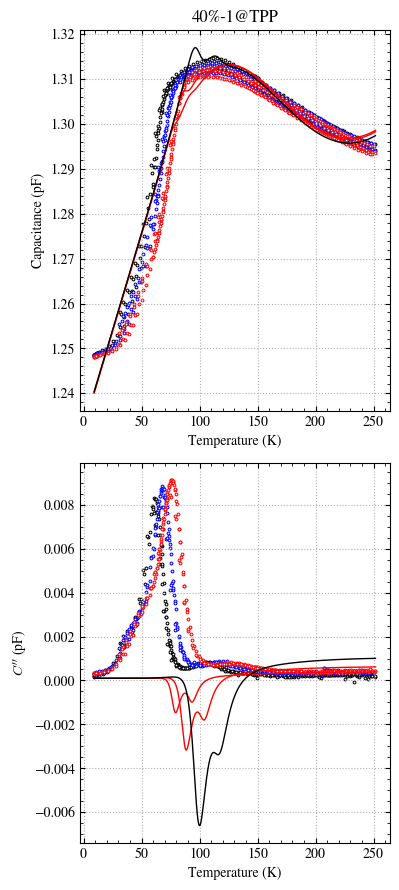

In [10]:
params = [fit.emat0, fit.emat1]
params.extend(fit.coupling_energy.flatten())
params.extend(fit.cole_term.flatten())
params.extend(fit.population.flatten())
params.extend(fit.activation_energy.flatten())

print(params)

def residuals(params: list, fit: ColeCole):
    emat0, emat1 = params[:2]
    coupling_energy = np.array(params[2:2+peaks]).reshape((peaks, 1, 1))
    cole_term = np.array(params[2+peaks:2+peaks+peaks]).reshape((peaks, 1, 1))
    population = np.array(params[2+peaks+peaks:2+3*peaks]).reshape((peaks, 1, 1))
    activation_energy = np.array(params[2+3*peaks:2+4*peaks]).reshape((peaks, 1, 1))
    cap, imag = fit.fitting_function(fit.temperature, fit.angular_frequency, fit.curie_temperature, fit.ln_attempt_time,
                                     activation_energy,
                                     coupling_energy, population, cole_term, emat0, emat1,
                                     fit.bare0, fit.bare1, fit.bare2, fit.td0, fit.td1, fit.td2)
    cap_error = fit.capacitance - cap
    im_error = fit.imaginary_capacitance - imag
    return np.sqrt(cap_error * cap_error + im_error * im_error).flatten() / weights
        
fit_result = least_squares(residuals, params, method='lm', args=(fit,))
std = np.sqrt(np.diagonal(np.linalg.inv(fit_result.jac.T @ fit_result.jac) * (fit_result.fun.T @ fit_result.fun / (fit_result.fun.size - fit_result.x.size))))

dof = np.product(fit.temperature.shape) - len(fit_result.x)
reduced_chi_sq = 2 * fit_result.cost / dof
print(f"reduced Chi^2 = {reduced_chi_sq}")

fit.emat0 = fit_result.x[0]
fit.emat1 = fit_result.x[1]
fit.coupling_energy = np.array(fit_result.x[2:2+peaks]).reshape((peaks, 1, 1))
fit.cole_term = np.array(fit_result.x[2+peaks:2+peaks+peaks]).reshape((peaks, 1, 1))
fit.population = np.array(fit_result.x[2+peaks+peaks:2+3*peaks]).reshape((peaks, 1, 1))
fit.activation_energy = np.array(fit_result.x[2+3*peaks:2+4*peaks]).reshape((peaks, 1, 1))

print(fit_result)
print(fit_result.x)
print(std)

fit.show_fit()

In [11]:
for ii in range(peaks):
    print(f"Energy = {int(fit.activation_energy[ii, 0, 0])} K = {fit.convert_energy(fit.activation_energy[ii, 0, 0], 'kcal'):.2f} kcal/mol")
    print(f"Asymm = {int(fit.coupling_energy[ii, 0, 0])} K = {fit.convert_energy(fit.coupling_energy[ii, 0, 0], 'kcal'):.2f} kcal/mol")
    print(f"cole = {fit.cole_term[ii, 0, 0]}")
    print(f"amplitude = {fit.population[ii, 0, 0]}")
    print("")

Energy = 2101 K = 4.18 kcal/mol
Asymm = 358 K = 0.71 kcal/mol
cole = -0.08717492825221541
amplitude = -67.55948519801719

Energy = 1769 K = 3.52 kcal/mol
Asymm = 433 K = 0.86 kcal/mol
cole = -0.07260029597324813
amplitude = -1135.9450342343725

Energy = 979 K = 1.95 kcal/mol
Asymm = 426 K = 0.85 kcal/mol
cole = 0.7453544423688606
amplitude = 438.4022337119266



(1000, 3)


(<Figure size 400x900 with 2 Axes>,
 array([<Axes: title={'center': '40%-1@TPP'}, xlabel='Temperature (K)', ylabel='Capacitance (pF)'>,
        <Axes: xlabel='Temperature (K)', ylabel="$C''$ (pF)">],
       dtype=object))

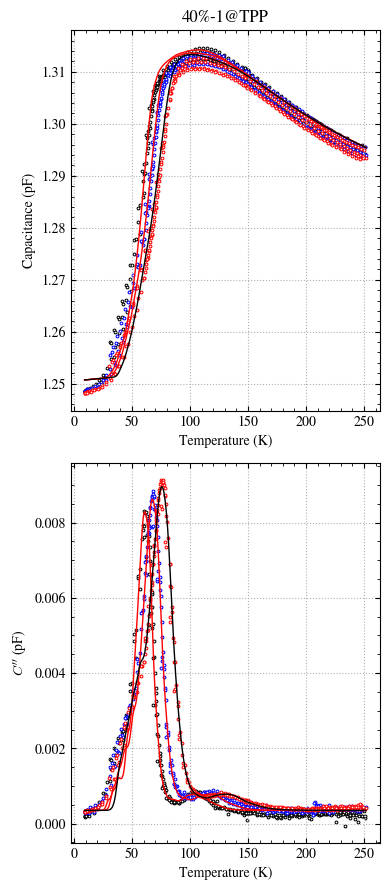

In [12]:
fit = Debye33(data, "40%-1@TPP")
fit.ln_attempt_time1 = -24.34
fit.ln_attempt_time2 = -29.633
fit.ln_attempt_time3 = -29
fit.activation_energy1 = 635.8
fit.activation_energy2 = 1326.4
fit.activation_energy3 = 2426.14
fit.coupling_energy1 = 196.164
fit.coupling_energy2 = 75.54
fit.coupling_energy3 = 0
fit.peak_width1 = 40
fit.peak_width2 = 65
fit.peak_width3 = 120

# fit.populations1 = np.array([0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0]).reshape((11, 1, 1))
# fit.populations2 = np.array([0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0]).reshape((11, 1, 1))
# fit.populations3 = np.array([0, 0, 0, 0, 0, 0.2, 0, 0, 0, 0, 0]).reshape((11, 1, 1))
fit.populations1 = np.array([0, 0, 11.43, 0.585, 8.356, 0.061, 7.977, 1.014, 1.9, 0, 0]).reshape((11, 1, 1))
fit.populations2 = np.array([0, 0.81, 0.38, 1.06, 1.29, 1.62, 2.52, 1.71, 2.5, 0, 0.66]).reshape((11, 1, 1))
fit.populations3 = np.array([0.03, 0.11, 0.01, 0.168, 0.11, 0.19288, 0.14, 0, 0.081, 0, 0]).reshape((11, 1, 1))
fit.bare0 = 1.19
fit.bare1 = 1.8e-5
fit.bare2 = 0
fit.td0 = 3.5e-4
fit.td1 = 0
fit.td2 = 0
fit.emat0 = 1.27
fit.emat1 = 0

# fit.bare0 = 1.19
# fit.bare1 = 1.8e-5
# fit.emat0 = 1.375
# fit.emat1 = 1e-4
# for ii in range(6):
#     fit.set_population(1, .5, ii)
#     fit.set_population(2, 5, ii)
#     fit.set_population(3, 0.1, ii)
# fit.activation_energy1 = 900
# fit.activation_energy2 = 1390
# fit.activation_energy3 = 2400
# fit.coupling_energy1 = 50
# fit.coupling_energy2 = 90
# fit.coupling_energy3 = 80
# fit.td0 = 2e-4
fit.show_fit()

In [13]:
fit.fit_1()

[635.8, 1326.4, 2426.14, 196.164, 75.54, 0, 40, 65, 120, 1.27, 0, 0.0, 0.0, 11.43, 0.585, 8.356, 0.061, 7.977, 1.014, 1.9, 0.0, 0.0, 0.0, 0.81, 0.38, 1.06, 1.29, 1.62, 2.52, 1.71, 2.5, 0.0, 0.66, 0.03, 0.11, 0.01, 0.168, 0.11, 0.19288, 0.14, 0.0, 0.081, 0.0, 0.0]


AttributeError: 'Debye33' object has no attribute 'ln_attempt_time'